# Time Series Forecast - VNINDEX

In [4]:
#!pip install vnstock plotly utilsforecast

In [5]:
#import necessary libraries
import statsmodels.api as sm
import matplotlib.pyplot as plt
from vnstock import Quote
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

import warnings
warnings.filterwarnings("ignore")

## 1.Import Data

In [6]:
end_date = '2025-10-25'

start_date_object = pd.to_datetime(end_date) - pd.DateOffset(years=15)
start_date_string = start_date_object.strftime('%Y-%m-%d')

quote = Quote(symbol='VNINDEX', source='TCBS')
df = quote.history(start=start_date_string, end=end_date,index=True)

df.set_index('time', inplace=True)
df.index = pd.to_datetime(df.index)

df

,open,high,low,close,volume
time,,,,,
2010-10-25,444.70,448.60,443.10,448.60,23427100
2010-10-26,450.20,458.20,450.20,455.10,30139330
2010-10-27,455.20,455.90,448.90,450.00,23349570
2010-10-28,448.60,451.50,448.30,450.10,20155160
2010-10-29,450.50,452.80,450.30,452.60,22494310
...,...,...,...,...,...
2025-10-07,1703.90,1703.90,1685.30,1685.30,799893649
2025-10-08,1701.06,1704.42,1680.87,1697.83,1017290489
2025-10-09,1702.76,1717.65,1697.83,1716.47,1044000610


## 2.Exploratory Data Analysis (EDA)

In [7]:
print(df.describe())

print(df.info())

              open         high          low        close        volume
count  3983.000000  3983.000000  3983.000000  3983.000000  3.983000e+03
mean    890.023510   895.545097   883.585270   889.900954  3.400905e+08
std     349.645941   351.587314   346.540323   349.462220  3.531827e+08
min     334.930000   339.320000   332.280000   336.730000  0.000000e+00
25%     568.485000   571.990000   565.090000   568.035000  9.317652e+07
50%     921.130000   926.320000   914.290000   921.270000  1.671453e+08
75%    1212.105000  1220.460000  1199.350000  1210.810000  5.515396e+08
max    1738.230000  1766.770000  1736.030000  1765.120000  2.698902e+09
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3983 entries, 2010-10-25 to 2025-10-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    3983 non-null   float64
 1   high    3983 non-null   float64
 2   low     3983 non-null   float64
 3   close   3983 non-null   float64
 4   v

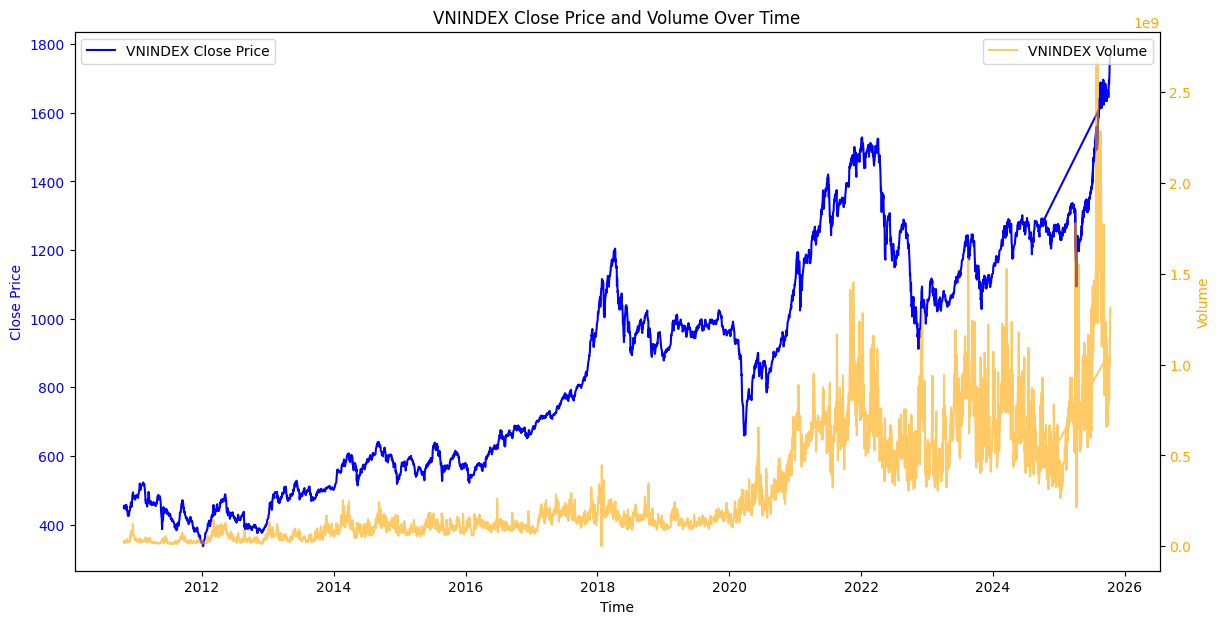

In [8]:
fig1, ax1 = plt.subplots(figsize=(14,7))
# Plot close price
ax1.plot(df.index, df['close'], label='VNINDEX Close Price', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
# plot volume on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(df.index, df['volume'], label='VNINDEX Volume', color='orange', alpha=0.6)
ax2.set_ylabel('Volume', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.legend(loc='upper right')

plt.title('VNINDEX Close Price and Volume Over Time')
plt.show()

In [9]:
# Decompose with annual-like period (252 trading days per year)
decomposition = sm.tsa.seasonal_decompose(df['close'], model='additive', period=252)

trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

# “Shock” = close price - trend - seasonality (optional metric)
shock = df['close'] - trend - seasonality

# Combine to visualize as full time series
time_series = df['close']

fig = make_subplots(
    rows=4, cols=1,
    subplot_titles=('Complete Time Series', 'Trend Component', 'Seasonal Component', 'Residual (Shock)'),
    vertical_spacing=0.08,
    row_heights=[0.4, 0.2, 0.2, 0.2]
)

# 1. Complete Time Series
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=time_series,
        mode='lines',
        line=dict(color='rgba(255, 0, 255, 1)'),
        name='Time Series'
    ),
    row=1, col=1
)

# 2. Trend
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=trend,
        mode='lines',
        line=dict(color='rgba(0, 255, 0, 1)'),
        name='Trend'
    ),
    row=2, col=1
)

# 3. Seasonality
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=seasonality,
        mode='lines',
        line=dict(color='rgba(0, 255, 255, 1)'),
        name='Seasonality'
    ),
    row=3, col=1
)

# 4. Residual / Shock
fig.add_trace(
    go.Scatter(
        x=df.index,
        y=residual,
        mode='lines',
        line=dict(color='rgba(255, 20, 147, 1)'),
        name='Residual'
    ),
    row=4, col=1
)


# Update layout & aesthetics

fig.update_layout(
    height=1000,
    width=1200,
    showlegend=False,
    title_text=f"VNINDEX Time Series Decomposition ({start_date_string} → {end_date})",
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(color='white')
)

fig.update_xaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor='rgba(128,128,128,0.2)',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='rgba(128,128,128,0.5)'
)
fig.update_yaxes(
    showgrid=True,
    gridwidth=1,
    gridcolor='rgba(128,128,128,0.2)',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='rgba(128,128,128,0.5)'
)

fig.show()

In [10]:
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=('Filtering', 'Smoothing', 'Forecasting'),
    vertical_spacing=0.08,
    row_heights=[0.33, 0.33, 0.33]
)

# ==============================================================
#  FILTERING: Moving Average
# ==============================================================
window = 20
filtered = np.convolve(df['close'], np.ones(window)/window, mode='valid')
filtered_df = pd.DataFrame(filtered, index=df.index[window-1:])
filtered_dates = filtered_df.index

filtered_std = np.std(filtered)
filtered_upper = filtered + 2*filtered_std
filtered_lower = filtered - 2*filtered_std

# Original Data
fig.add_trace(
    go.Scatter(x=df.index, y=df['close'], mode='lines', line=dict(color='rgba(0,255,255,1)'), name='Original'),
    row=1, col=1
)

# Filtered Line
fig.add_trace(
    go.Scatter(x=filtered_dates, y=filtered, mode='lines', line=dict(color='rgba(255,20,147,1)'), name='Filtered'),
    row=1, col=1
)

# Confidence Band
fig.add_trace(
    go.Scatter(x=filtered_dates, y=filtered_upper, mode='lines', line=dict(color='rgba(255,20,147,0.2)'), showlegend=False),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=filtered_dates, y=filtered_lower, mode='lines', line=dict(color='rgba(255,20,147,0.2)'), fill='tonexty', showlegend=False),
    row=1, col=1
)

#  SMOOTHING: Exponential Smoothing
# ==============================================================
alpha = 0.1
smoothed = [df['close'][0]]
for i in range(1, len(df['close'])):
    smoothed.append(alpha * df['close'][i] + (1 - alpha) * smoothed[i-1])

smoothed_std = np.std(smoothed)
smoothed_std = np.std(smoothed)
smoothed_upper = np.array(smoothed) + 2*smoothed_std
smoothed_lower = np.array(smoothed) - 2*smoothed_std

fig.add_trace(
    go.Scatter(x=df.index, y=df['close'], mode='lines', line=dict(color='rgba(0,255,255,1)'), showlegend=False),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.index, y=smoothed, mode='lines', line=dict(color='rgba(147,0,255,1)'), name='Smoothed'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.index, y=smoothed_upper, mode='lines', line=dict(color='rgba(147,0,255,0.2)'), showlegend=False),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=df.index, y=smoothed_lower, mode='lines', line=dict(color='rgba(147,0,255,0.2)'), fill='tonexty', showlegend=False),
    row=2, col=1
)



#  FORECASTING: Simple Random Walk Projection
# ==============================================================
forecast_days = 360
last_price = df['close'].iloc[-1]
forecast = [last_price]
forecast_std_list = []
current_std = np.std(df['close'].iloc[-window:])

for _ in range(forecast_days-1):
    forecast.append(forecast[-1] * (1 + np.random.normal(0.0003, 0.01)))
    current_std *= 1.1
    forecast_std_list.append(current_std)

forecast_dates = [df.index[-1] + timedelta(days=i) for i in range(forecast_days)]

forecast_std = np.std(df['close'].iloc[-window:])
forecast_upper = np.array(forecast) + 2 * forecast_std
forecast_lower = np.array(forecast) - 2 * forecast_std

fig.add_trace(
    go.Scatter(x=df.index, y=df['close'], mode='lines', line=dict(color='rgba(0,255,255,1)'), showlegend=False),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=forecast_dates, y=forecast, mode='lines', line=dict(color='rgba(57,255,20,1)'), name='Forecast'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=forecast_dates, y=forecast_upper, mode='lines', line=dict(color='rgba(57,255,20,0.2)'), showlegend=False),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=forecast_dates, y=forecast_lower, mode='lines', line=dict(color='rgba(57,255,20,0.2)'), fill='tonexty', showlegend=False),
    row=3, col=1
)

# --------------------------------------------------------------
# 4️ Layout settings
# --------------------------------------------------------------
fig.update_layout(
    width=1200,
    height=1200,
    title='Time Series Analysis on VNINDEX: Filtering, Smoothing, and Forecasting',
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(color='white')
)

fig.update_xaxes(
    showgrid=True,
    gridcolor='rgba(128,128,128,0.2)',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='rgba(128,128,128,0.5)'
)
fig.update_yaxes(
    showgrid=True,
    gridcolor='rgba(128,128,128,0.2)',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='rgba(128,128,128,0.5)'
)

fig.show()

# Task
Explain the error in the selected code, fix it if possible, and incorporate the changes into the existing code. If fixing is not possible, diagnose the error.

## Forecasting models

### Subtask:
Implement and train the specified forecasting models (Historic Average, Moving Average, Seasonal Decomposition, ARIMA, and SARIMA).


**Reasoning**:
Implement and train the specified forecasting models (Historic Average, Moving Average, Seasonal Decomposition, ARIMA, and SARIMA) to generate forecasts for a specified number of future days.



In [ ]:
# Define the number of future days to forecast
forecast_days = 360

# 1. Historic Average Forecast
historic_average = df['close'].mean()
historic_average_forecast = [historic_average] * forecast_days

# 2. Moving Average Forecast
window = 20
moving_average_forecast = []
last_window = df['close'].iloc[-window:].values
for _ in range(forecast_days):
    next_value = last_window.mean()
    moving_average_forecast.append(next_value)
    # To make it a proper rolling forecast, we would need to add the forecasted value and drop the oldest,
    # but for a simple projection based on the last window, we just repeat the average.
    # For a more realistic forecast, you might consider adding some noise or a trend.
    last_window = np.append(last_window[1:], next_value)


# 3. Seasonal Decomposition Forecast
# Use the existing decomposition results (trend, seasonality, residual)
# Extend the trend linearly and repeat the seasonality
last_trend_value = trend.iloc[-1]
# Simple linear extension of the trend
trend_forecast = [last_trend_value + (i * (trend.iloc[-1] - trend.iloc[-2])) for i in range(1, forecast_days + 1)]

# Repeat the last period of seasonality
seasonal_period = 252
seasonal_forecast = seasonality.iloc[-seasonal_period:].tolist() * (forecast_days // seasonal_period + 1)
seasonal_forecast = seasonal_forecast[:forecast_days]

# For the residual, we'll assume it averages out to zero in the future
residual_forecast = [0] * forecast_days

seasonal_decomposition_forecast = np.array(trend_forecast) + np.array(seasonal_forecast) + np.array(residual_forecast)


# 4. ARIMA Forecast
# Determine p, d, q (example values, these should be determined through analysis like ACF/PACF or auto_arima)
p, d, q = 5, 1, 0
# Fit the ARIMA model
arima_model = sm.tsa.arima.ARIMA(df['close'], order=(p, d, q))
arima_results = arima_model.fit()
# Generate forecast
arima_forecast = arima_results.forecast(steps=forecast_days)

# 5. SARIMA Forecast
# Determine p, d, q, P, D, Q, s (example values, these should be determined through analysis)
# Assuming annual seasonality (s=252)
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 0, 252
sarima_model = sm.tsa.statespace.SARIMAX(df['close'],
                                        order=(p, d, q),
                                        seasonal_order=(P, D, Q, s),
                                        enforce_stationarity=False,
                                        enforce_invertibility=False)
sarima_results = sarima_model.fit()
# Generate forecast
sarima_forecast = sarima_results.forecast(steps=forecast_days)

# Create forecast dates
last_date = df.index[-1]
forecast_dates = [last_date + timedelta(days=i) for i in range(1, forecast_days + 1)]

# Display the forecasts (first few values)
print("Historic Average Forecast (first 5):", historic_average_forecast[:5])
print("Moving Average Forecast (first 5):", moving_average_forecast[:5])
print("Seasonal Decomposition Forecast (first 5):", seasonal_decomposition_forecast[:5])
print("ARIMA Forecast (first 5):", arima_forecast.values[:5])
print("SARIMA Forecast (first 5):", sarima_forecast.values[:5])

# Visualize the forecasts
fig = go.Figure()

# Plot original data
fig.add_trace(go.Scatter(x=df.index, y=df['close'], mode='lines', name='Original'))

# Plot forecasts
fig.add_trace(go.Scatter(x=forecast_dates, y=historic_average_forecast, mode='lines', name='Historic Average Forecast'))
fig.add_trace(go.Scatter(x=forecast_dates, y=moving_average_forecast, mode='lines', name='Moving Average Forecast'))
fig.add_trace(go.Scatter(x=forecast_dates, y=seasonal_decomposition_forecast, mode='lines', name='Seasonal Decomposition Forecast'))
fig.add_trace(go.Scatter(x=forecast_dates, y=arima_forecast, mode='lines', name='ARIMA Forecast'))
fig.add_trace(go.Scatter(x=forecast_dates, y=sarima_forecast, mode='lines', name='SARIMA Forecast'))

# Update layout
fig.update_layout(
    title='VNINDEX Forecasts from Different Models',
    xaxis_title='Time',
    yaxis_title='Close Price',
    showlegend=True,
    plot_bgcolor='rgba(0,0,0,0)',
    paper_bgcolor='rgba(0,0,0,0)',
    font=dict(color='white')
)

fig.update_xaxes(
    showgrid=True,
    gridcolor='rgba(128,128,128,0.2)',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='rgba(128,128,128,0.5)'
)
fig.update_yaxes(
    showgrid=True,
    gridcolor='rgba(128,128,128,0.2)',
    zeroline=True,
    zerolinewidth=1,
    zerolinecolor='rgba(128,128,128,0.5)'
)

fig.show()


📋 Kết nối tài khoản Google Drive để lưu các thiết lập của dự án.
Dữ liệu phiên làm việc với Colab của bạn sẽ bị xóa nếu không lưu trữ vào Google Drive.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 4. Model Evaluation

**Reasoning**:
Evaluate the performance of each forecasting model to compare their accuracy and identify the most suitable model for forecasting the VNINDEX.

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Prepare actual values for evaluation (assuming the forecast_days are within the available data)
# If forecast_days extend beyond the available data, we would need to use a test set
# For this example, let's assume we evaluate on the last `forecast_days` of the original data
# Note: In a real-world scenario, you would typically split your data into training and testing sets *before* training the models.
# Since the models were trained on the full dataset here, this evaluation is illustrative.

actual_values = df['close'].iloc[-forecast_days:].values

# Ensure all forecasts have the same length as actual_values
historic_average_forecast_eval = historic_average_forecast[:forecast_days]
moving_average_forecast_eval = moving_average_forecast[:forecast_days]
seasonal_decomposition_forecast_eval = seasonal_decomposition_forecast[:forecast_days]
arima_forecast_eval = arima_forecast.values[:forecast_days]
sarima_forecast_eval = sarima_forecast.values[:forecast_days]


# Calculate evaluation metrics
def evaluate_forecast(actual, forecast):
    rmse = sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    # You can add more metrics here, e.g., MAPE
    return {'RMSE': rmse, 'MAE': mae}

historic_average_metrics = evaluate_forecast(actual_values, historic_average_forecast_eval)
moving_average_metrics = evaluate_forecast(actual_values, moving_average_forecast_eval)
seasonal_decomposition_metrics = evaluate_forecast(actual_values, seasonal_decomposition_forecast_eval)
arima_metrics = evaluate_forecast(actual_values, arima_forecast_eval)
sarima_metrics = evaluate_forecast(actual_values, sarima_forecast_eval)

# Display metrics
print("Historic Average Metrics:", historic_average_metrics)
print("Moving Average Metrics:", moving_average_metrics)
print("Seasonal Decomposition Metrics:", seasonal_decomposition_metrics)
print("ARIMA Metrics:", arima_metrics)
print("SARIMA Metrics:", sarima_metrics)

# You could also create a pandas DataFrame for better visualization of metrics
metrics_df = pd.DataFrame({
    'Model': ['Historic Average', 'Moving Average', 'Seasonal Decomposition', 'ARIMA', 'SARIMA'],
    'RMSE': [historic_average_metrics['RMSE'], moving_average_metrics['RMSE'], seasonal_decomposition_metrics['RMSE'], arima_metrics['RMSE'], sarima_metrics['RMSE']],
    'MAE': [historic_average_metrics['MAE'], moving_average_metrics['MAE'], seasonal_decomposition_metrics['MAE'], arima_metrics['MAE'], sarima_metrics['MAE']]
})

display(metrics_df)